In [48]:
# We want to identify which customers are most likely to buy a product, so the business can focus marketing efforts on the right customers instead of everyone.

In [49]:
# This saves:

# -- Marketing cost 

# -- Time ⏱️

# -- Improves conversion rates 📈

In [50]:
#| Column         | Meaning (Simple)                     |
#| -------------- | ------------------------------------ |
#| Recency        | How recently the customer interacted |
#| Frequency      | How often they purchase              |
#| Monetary       | How much money they spend            |
#| Email Clicks   | How engaged they are with emails     |
#| Website Visits | How often they visit the website     |
#| Purchase       | Whether they actually bought or not  |


In [51]:
# Create Customer-Level Data

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier


In [53]:
np.random.seed(42)

customers = pd.DataFrame({
    'customer_id': range(1, 501),
    'recency_days': np.random.randint(1, 180, 500),
    'frequency': np.random.randint(1, 20, 500),
    'monetary_value': np.random.randint(100, 5000, 500),
    'email_clicks': np.random.randint(0, 10, 500),
    'website_visits': np.random.randint(1, 30, 500)
})

customers.head()


,customer_id,recency_days,frequency,monetary_value,email_clicks,website_visits
0,1,103,12,3019,3,11
1,2,93,14,2697,0,7
2,3,15,2,3305,5,24
3,4,107,19,4907,0,28
4,5,72,18,914,9,14


In [54]:
#Create Purchase Target Variabl

In [55]:
customers['purchase'] = (
    (customers['recency_days'] < 60) &
    (customers['frequency'] > 7) &
    (customers['monetary_value'] > 1500)
).astype(int)


In [56]:
# RFM SCORING

In [57]:
# ------------------------------
# RFM ANALYSIS
# ------------------------------

# Create a separate RFM table using key customer value metrics
rfm = customers[['customer_id', 'recency_days', 'frequency', 'monetary_value']].copy()

# Assign Recency score (recent customers get higher scores)
rfm['R_score'] = pd.qcut(rfm['recency_days'], 5, labels=[5,4,3,2,1])

# Assign Frequency score (frequent buyers get higher scores)
rfm['F_score'] = pd.qcut(rfm['frequency'], 5, labels=[1,2,3,4,5])

# Assign Monetary score (high spenders get higher scores)
rfm['M_score'] = pd.qcut(rfm['monetary_value'], 5, labels=[1,2,3,4,5])

# Calculate total RFM score
rfm['RFM_score'] = (
    rfm['R_score'].astype(int) +
    rfm['F_score'].astype(int) +
    rfm['M_score'].astype(int)
)


rfm.head()


,customer_id,recency_days,frequency,monetary_value,R_score,F_score,M_score,RFM_score
0,1,103,12,3019,3,3,3,9
1,2,93,14,2697,3,4,3,10
2,3,15,2,3305,5,1,4,10
3,4,107,19,4907,3,5,5,13
4,5,72,18,914,3,5,1,9


In [58]:
#In simple terms:

#We divide customers into 5 groups for each metric

#Best customers get higher scores

#Higher total RFM score = more valuable customer

In [59]:
# Merge RFM Back to Main Data

In [60]:
customers = customers.merge(
    rfm[['customer_id', 'RFM_score']],
    on='customer_id',
    how='left'
)


In [61]:
# Predictive Model

In [62]:
# Model Training

In [63]:
X = customers.drop(['customer_id', 'purchase'], axis=1)
y = customers['purchase']


In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [65]:
#Train the model on 75% customers

#Test on 25% new customers

In [66]:
# puts all numbers on the same scale so the model isn’t biased.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [67]:
# Train the Model

In [68]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train_scaled, y_train)


GradientBoostingClassifier(random_state=42)

In [69]:
#The model:

#Looks at past customer behavior

#Learns patterns

#Predicts who will likely buy next

In [70]:
# Evaluate Model

In [71]:
y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.992
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       107
           1       1.00      0.94      0.97        18

    accuracy                           0.99       125
   macro avg       1.00      0.97      0.98       125
weighted avg       0.99      0.99      0.99       125



In [72]:
# Feature Importance

In [73]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)


In [74]:
print(feature_importance)

          Feature  Importance
5       RFM_score    0.396170
0    recency_days    0.357934
1       frequency    0.168306
2  monetary_value    0.077591
3    email_clicks    0.000000
4  website_visits    0.000000


In [75]:
# I built a customer propensity model using Python and RFM analysis. I first segmented customers based on recency, frequency, and monetary value to capture business intuition. Then I combined these RFM scores with behavioral data like email engagement and website visits to train a machine learning model. The model helps identify high-propensity customers so marketing teams can target them more effectively.

In [76]:
# Create Segmentation Function

In [77]:
def segment_customer(rfm_score):
    if rfm_score >= 13:
        return 'Champions'
    elif rfm_score >= 10:
        return 'Loyal Customers'
    elif rfm_score >= 8:
        return 'Potential Loyalists'
    elif rfm_score >= 5:
        return 'At Risk'
    else:
        return 'Low Value'


In [78]:
# Appli Segmentation function

In [79]:
customers['customer_segment'] = customers['RFM_score'].apply(segment_customer)

customers[['customer_id', 'RFM_score', 'customer_segment']].head()


,customer_id,RFM_score,customer_segment
0,1,9,Potential Loyalists
1,2,10,Loyal Customers
2,3,10,Loyal Customers
3,4,13,Champions
4,5,9,Potential Loyalists


In [80]:
# Visualize Customer Segments

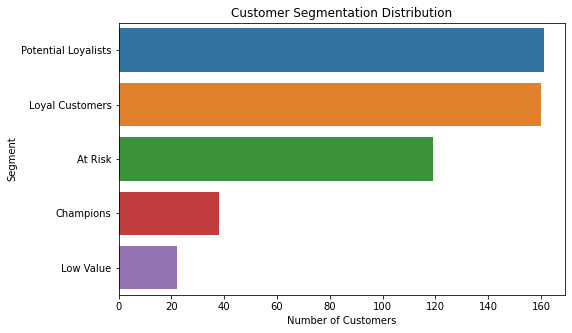

In [81]:
plt.figure(figsize=(8,5))
sns.countplot(
    y='customer_segment',
    data=customers,
    order=customers['customer_segment'].value_counts().index
)
plt.title('Customer Segmentation Distribution')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.show()


In [82]:
# Business Insights

In [83]:
### Customer Segmentation Insights
#- Champions represent the highest-value customers and should be prioritized for loyalty programs.
#- Loyal Customers show consistent purchasing behavior and can be targeted for upselling.
#- Potential Loyalists are ideal for nurturing campaigns to increase engagement.
#- At Risk customers require re-engagement strategies such as personalized offers.
#- Low Value customers can be targeted with cost-effective or automated campaigns.


In [84]:
# Use Segments in Predictive Model

In [85]:
segment_encoded = pd.get_dummies(customers['customer_segment'], drop_first=True)
X = pd.concat([X, segment_encoded], axis=1)


In [86]:
print(segment_encoded)

     Champions  Low Value  Loyal Customers  Potential Loyalists
0            0          0                0                    1
1            0          0                1                    0
2            0          0                1                    0
3            1          0                0                    0
4            0          0                0                    1
..         ...        ...              ...                  ...
495          0          0                0                    0
496          0          0                0                    1
497          0          0                0                    1
498          1          0                0                    0
499          0          0                0                    0

[500 rows x 4 columns]


In [87]:
# After calculating RFM scores, I created customer segments like Champions, Loyal Customers, and At-Risk customers. This allows the business to take targeted actions instead of one-size-fits-all campaigns. I then combined segmentation with a predictive model to identify customers most likely to purchase, making the insights both strategic and actionable